In [1]:
import numpy as np
import pickle
import random
import pandas as pd
from model import Brain
from submodels import factories
import argparse
import os
from pathlib import Path
from traceback import print_exc
import re
import matplotlib.pyplot as plt
from jf.db import DB
from lib.plot import plot_2d_positions_colors
from tqdm import tqdm
import time

In [2]:
from vizualisation.plot import mean_sd, plot_lines_number_cells

In [3]:
%%javascript
document.title = "Algorithm running !"

<IPython.core.display.Javascript object>

## Setup parameters for proper smooth

In [4]:
def run_with_options(**kwargs):
    ccls = factories["triambimutant"](**kwargs)

    bb = Brain(time_step=0.5, verbose=False, start_population=6,
            cell_cls=ccls.generate, end_time=80, start_time=49, silent=True)
    bb.run()
    return bb.stats.iloc[-1]["progenitor_pop_size"]

In [5]:
def multi_plot(ls, args=None, save=False):
    line = mean_sd(ls)
    plot_lines_number_cells([line])
    plt.title(str(args))
    if save:
        plt.savefig(str(time.time()) + ".png")
    plt.show()
    plt.close()
    
def run_one(args):
    ccls = factories["triambimutant"](**args)

    bb = Brain(time_step=0.5, verbose=False, start_population=6,
            cell_cls=ccls.generate, end_time=90, start_time=49, silent=True)
    bb.run()
    return dict(x=list(bb.stats.index), y=list(bb.stats.progenitor_pop_size / bb.stats.progenitor_pop_size.iloc[0]))
    
def run_full(args):
    res = [run_one(args) for x in tqdm(range(5))]
    multi_plot(res, args)

100%|██████████| 5/5 [03:38<00:00, 43.62s/it]


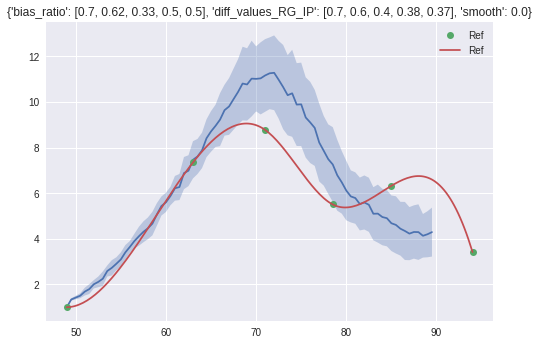

In [6]:
run_full(dict(bias_ratio=[0.7, 0.62, 0.33, 0.5, 0.5], diff_values_RG_IP=[.7, .6, .4, 0.38, 0.37], smooth=0.))  # ok

100%|██████████| 5/5 [04:43<00:00, 56.63s/it]


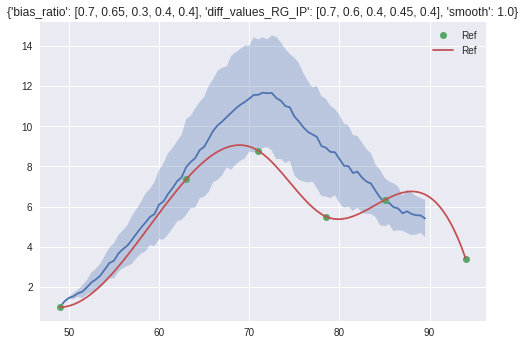

In [7]:
run_full(dict(bias_ratio=[0.7, 0.65, 0.30, 0.4, 0.4], diff_values_RG_IP=[.7, .6, .4, 0.45, 0.4], smooth=1.))  # ok

100%|██████████| 5/5 [02:11<00:00, 26.29s/it]


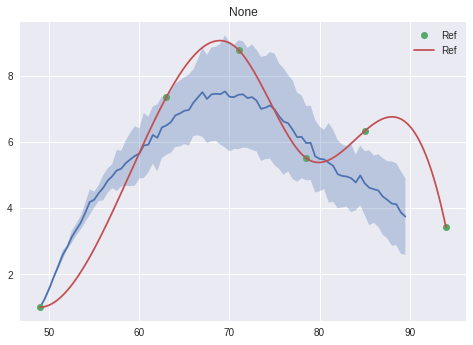

In [8]:
def run_one_tristate():
    ccls = factories["tristate1"](smooth=1.0, bias_ratio=[0.68, 0.56, 0.43, 0.38, 0.33],
                             diff_values_RG_IP=[.63, .53, .43, 0.38, 0.33], coeff_mutant=1.)

    bb = Brain(time_step=0.5, verbose=False, start_population=6,
            cell_cls=ccls.generate, end_time=90, start_time=49, silent=True)
    bb.run()
    return dict(x=list(bb.stats.index), y=list(bb.stats.progenitor_pop_size / bb.stats.progenitor_pop_size.iloc[0]))

res_tristate = [run_one_tristate() for x in tqdm(range(5))]
multi_plot(res_tristate)

In [9]:
args = dict(bias_ratio=[0.7, 0.62, 0.33, 0.5, 0.5], diff_values_RG_IP=[.7, .6, .4, 0.45, 0.4], smooth=0., id_mutant=20)
ccls = factories["triambimutant"](**args)

bb = Brain(time_step=0.5, verbose=False, start_population=6,
        cell_cls=ccls.generate, end_time=90, start_time=49, silent=True)
bb.run()

In [10]:
bb.stats.columns

Index(['progenitor_pop_size', 'size_type_IP', 'size_type_Mutant',
       'size_type_RG', 'time', 'whole_pop_size', 'size_type_PostMitotic',
       'size_type_GP'],
      dtype='object')

In [11]:
history = bb.build_cell_history()
history.head()

,Tc_h,appear_time,child1,child2,division_time,index,type
0,23.863322,49.0,36,37,49.136814,0.0,RG
1,36.811019,49.0,66,67,50.055581,1.0,RG
2,31.837263,49.0,46,47,49.838331,2.0,RG
3,45.163226,49.0,68,69,50.283689,3.0,RG
4,31.851160,49.0,48,49,49.872077,4.0,RG


In [12]:
idx = 21
db = DB(pos=bb.snapshots[idx]["tissue"], corresp=bb.snapshots[idx]["tissue_ids"], history=history)

In [13]:
db.link(db.rel.pos.index, db.rel.corresp.index)
db.link(db.rel.corresp.value, db.rel.history.index)

In [14]:
colors = dict(RG="b", IP="g", Mutant="k", PostMitotic="r", GP="y")

In [15]:
ls_show = [(el.pos.value, colors[el.history.type]) for el in db.pos]

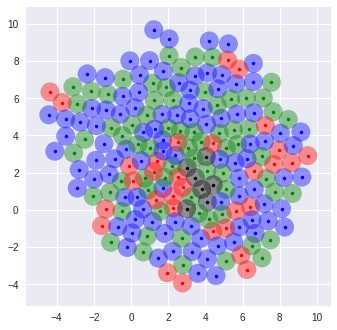

In [16]:
plot_2d_positions_colors(*zip(*ls_show))

## Setup mutant values

- Select correct value for the mutant (for later experiments)
- Provide some images of the evolution of the mutant in a smooth = 0, 0.5 and 1

In [17]:
def show_bb(bb, idx=21):
    history = bb.build_cell_history()
    db = DB(pos=bb.snapshots[idx]["tissue"], corresp=bb.snapshots[idx]["tissue_ids"], history=history)

    db.link(db.rel.pos.index, db.rel.corresp.index)
    db.link(db.rel.corresp.value, db.rel.history.index)

    colors = dict(RG="b", IP="g", Mutant="k", PostMitotic="r", GP="y")

    ls_show = [(el.pos.value, colors[el.history.type]) for el in db.pos]

    plot_2d_positions_colors(*zip(*ls_show))

100%|██████████| 5/5 [04:16<00:00, 51.33s/it]


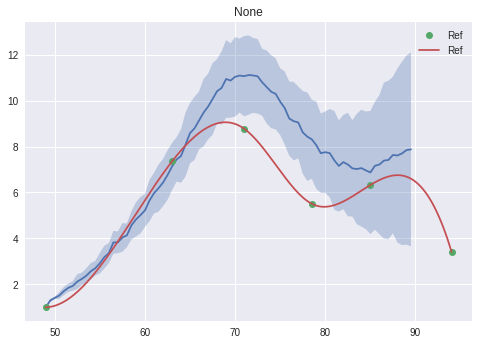

In [18]:
def run_one_tristate():
    global bb
    args = dict(bias_ratio=[0.7, 0.62, 0.33, 0.5, 0.5], diff_values_RG_IP=[.7, .6, .4, 0.45, 0.4],
                smooth=0., id_mutant=20, coeff_mutant=0.5)
    ccls = factories["triambimutant"](**args)

    bb = Brain(time_step=0.5, verbose=False, start_population=6,
            cell_cls=ccls.generate, end_time=90, start_time=49, silent=True)
    bb.run()
    return dict(x=list(bb.stats.index), y=list(bb.stats.progenitor_pop_size / bb.stats.progenitor_pop_size.iloc[0]))

res_tristate = [run_one_tristate() for x in tqdm(range(5))]
multi_plot(res_tristate)

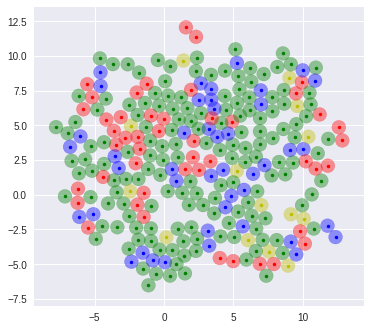

In [19]:
show_bb(bb, 60)

100%|██████████| 5/5 [07:19<00:00, 87.90s/it]


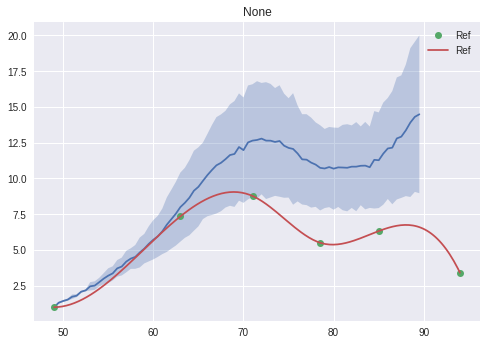

In [20]:
def run_one_sm():
    global bb
    args = dict(bias_ratio=[0.7, 0.62, 0.33, 0.5, 0.5], diff_values_RG_IP=[.7, .6, .4, 0.45, 0.4],
                smooth=1., id_mutant=20, coeff_mutant=0.3)
    ccls = factories["triambimutant"](**args)

    bb = Brain(time_step=0.5, verbose=False, start_population=6,
            cell_cls=ccls.generate, end_time=90, start_time=49, silent=True)
    bb.run()
    return dict(x=list(bb.stats.index), y=list(bb.stats.progenitor_pop_size / bb.stats.progenitor_pop_size.iloc[0]))

res_sm = [run_one_sm() for x in tqdm(range(5))]
multi_plot(res_sm)

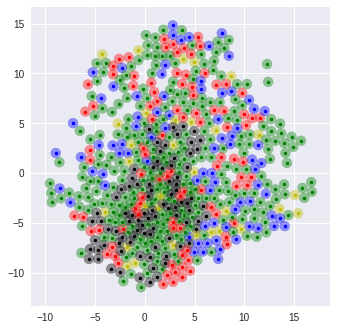

In [21]:
show_bb(bb, 60)

In [22]:
%%javascript
document.title = "Algorithm finished !"

<IPython.core.display.Javascript object>